# Interaktionsanalyse

## Imports

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
import time
warnings.filterwarnings('ignore')

## Data Load

In [38]:
#Daten laden 
train = pd.read_csv("Data/preprocessed/train_preprocessed.csv")
test = pd.read_csv("Data/preprocessed/test_preprocessed.csv") 
target = pd.read_csv("Data/preprocessed/test_target.csv")

# Features & Ziel trennen 
X_train = train.drop(columns=["AdoptionSpeed", "PetID"])
y_train = train["AdoptionSpeed"]

X_test = test.drop(columns=["PetID"])
y_test = target["AdoptionSpeed"]

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")
print(f"Target Klassen: {sorted(y_train.unique())}")

Training Set: (13275, 21), Test Set: (2845, 21)
Target Klassen: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


## Hypothese 4: Hohe strukturelle Komplexität (max_depth) erfordert sowohl reduzierte Lernraten (learning_rate↓) als auch verstärktes Sampling-basiertes Regularisieren (subsample) für optimale Performance.

In [39]:
# Parameter-Grid für Hypothese 4
param_grid_h4 = {
    'max_depth': [3, 6, 9, 12],           # Von niedrig zu hoch
    'learning_rate': [0.3, 0.2, 0.1, 0.05], # Von hoch zu niedrig  
    'subsample': [1.0, 0.8, 0.6, 0.4]     # Von hoch zu niedrig
}


In [40]:
# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_params(max_depth, learning_rate, subsample):
    """Evaluiert eine Parameterkombination mit Cross-Validation"""
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        use_label_encoder=False,
        eval_metric='mlogloss',
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42
    )
    
    # Cross-Validation F1 Score (weighted für Multi-Class)
    f1_scores = cross_val_score(model, X_train, y_train, 
                               cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    # Cross-Validation Accuracy
    acc_scores = cross_val_score(model, X_train, y_train, 
                                cv=cv, scoring='accuracy', n_jobs=-1)
    
    return {
        'max_depth': max_depth,
        'learning_rate': learning_rate, 
        'subsample': subsample,
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std(),
        'accuracy_mean': acc_scores.mean(),
        'accuracy_std': acc_scores.std()
    }

print("Starte Hypothese 4 Experimente...")
print("Erwartung: max_depth↑ → learning_rate↓ UND subsample↓")
print("=" * 60)

Starte Hypothese 4 Experimente...
Erwartung: max_depth↑ → learning_rate↓ UND subsample↓


In [ ]:
# Alle Parameterkombinationen testen
results_h4 = []
total_combinations = len(param_grid_h4['max_depth']) * len(param_grid_h4['learning_rate']) * len(param_grid_h4['subsample'])

for i, (max_depth, learning_rate, subsample) in enumerate(
    product(param_grid_h4['max_depth'], 
            param_grid_h4['learning_rate'], 
            param_grid_h4['subsample']), 1):
    
    print(f"[{i:2d}/{total_combinations}] Testing: max_depth={max_depth}, lr={learning_rate}, subsample={subsample}")
    
    result = evaluate_params(max_depth, learning_rate, subsample)
    results_h4.append(result)


[ 1/64] Testing: max_depth=3, lr=0.3, subsample=1.0
[ 2/64] Testing: max_depth=3, lr=0.3, subsample=0.8
[ 3/64] Testing: max_depth=3, lr=0.3, subsample=0.6
[ 4/64] Testing: max_depth=3, lr=0.3, subsample=0.4
[ 5/64] Testing: max_depth=3, lr=0.2, subsample=1.0
[ 6/64] Testing: max_depth=3, lr=0.2, subsample=0.8
[ 7/64] Testing: max_depth=3, lr=0.2, subsample=0.6
[ 8/64] Testing: max_depth=3, lr=0.2, subsample=0.4
[ 9/64] Testing: max_depth=3, lr=0.1, subsample=1.0
[10/64] Testing: max_depth=3, lr=0.1, subsample=0.8
[11/64] Testing: max_depth=3, lr=0.1, subsample=0.6
[12/64] Testing: max_depth=3, lr=0.1, subsample=0.4
[13/64] Testing: max_depth=3, lr=0.05, subsample=1.0
[14/64] Testing: max_depth=3, lr=0.05, subsample=0.8
[15/64] Testing: max_depth=3, lr=0.05, subsample=0.6
[16/64] Testing: max_depth=3, lr=0.05, subsample=0.4
[17/64] Testing: max_depth=6, lr=0.3, subsample=1.0
[18/64] Testing: max_depth=6, lr=0.3, subsample=0.8
[19/64] Testing: max_depth=6, lr=0.3, subsample=0.6
[20/64] 

In [ ]:
# Ergebnisse in DataFrame
df_results_h4 = pd.DataFrame(results_h4)

print("\nTOP 10 Konfigurationen (nach F1 Score):")
print("=" * 60)
top_10_f1 = df_results_h4.nlargest(10, 'f1_mean')
for idx, row in top_10_f1.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"Acc: {row['accuracy_mean']:.4f} | "
          f"max_depth={row['max_depth']}, lr={row['learning_rate']}, subsample={row['subsample']}")

# HYPOTHESEN-ANALYSE
print("\nHYPOTHESEN-ANALYSE:")
print("=" * 60)



TOP 10 Konfigurationen (nach F1 Score):
F1: 0.4251±0.012 | Acc: 0.4313 | max_depth=12.0, lr=0.1, subsample=0.8
F1: 0.4236±0.007 | Acc: 0.4277 | max_depth=12.0, lr=0.3, subsample=1.0
F1: 0.4215±0.010 | Acc: 0.4263 | max_depth=12.0, lr=0.2, subsample=0.8
F1: 0.4193±0.011 | Acc: 0.4250 | max_depth=9.0, lr=0.2, subsample=1.0
F1: 0.4185±0.008 | Acc: 0.4231 | max_depth=12.0, lr=0.2, subsample=1.0
F1: 0.4183±0.012 | Acc: 0.4231 | max_depth=9.0, lr=0.2, subsample=0.8
F1: 0.4172±0.006 | Acc: 0.4214 | max_depth=9.0, lr=0.3, subsample=1.0
F1: 0.4154±0.007 | Acc: 0.4246 | max_depth=12.0, lr=0.05, subsample=0.8
F1: 0.4147±0.015 | Acc: 0.4205 | max_depth=12.0, lr=0.1, subsample=0.6
F1: 0.4141±0.007 | Acc: 0.4196 | max_depth=12.0, lr=0.1, subsample=1.0

HYPOTHESEN-ANALYSE:


In [ ]:
# 1. Analyse: Für jede max_depth, welche lr/subsample Kombination ist optimal?
best_per_depth = df_results_h4.loc[df_results_h4.groupby('max_depth')['f1_mean'].idxmax()]

print("Beste Konfiguration pro max_depth:")
for _, row in best_per_depth.iterrows():
    print(f"max_depth={int(row['max_depth']):2d} → lr={row['learning_rate']:.2f}, subsample={row['subsample']:.1f} "
      f"(F1: {row['f1_mean']:.4f})")


Beste Konfiguration pro max_depth:
max_depth= 3 → lr=0.30, subsample=0.8 (F1: 0.3773)
max_depth= 6 → lr=0.30, subsample=1.0 (F1: 0.4058)
max_depth= 9 → lr=0.20, subsample=1.0 (F1: 0.4193)
max_depth=12 → lr=0.10, subsample=0.8 (F1: 0.4251)


In [ ]:
print("\nKORRELATIONS-ANALYSE:")

best_per_depth = (
    df_results_h4.loc[df_results_h4.groupby('max_depth')['f1_mean'].idxmax()]
    .sort_values('max_depth')
    .reset_index(drop=True)
)

depths = best_per_depth['max_depth'].astype(float).reset_index(drop=True)
opt_lr = best_per_depth['learning_rate'].astype(float).reset_index(drop=True)
opt_sub = best_per_depth['subsample'].astype(float).reset_index(drop=True)

correlation_depth_lr = depths.corr(opt_lr)
correlation_depth_subsample = depths.corr(opt_sub)

print(f"Korrelation max_depth ↔ optimale learning_rate: {correlation_depth_lr:.3f}")
print(f"Korrelation max_depth ↔ optimale subsample:     {correlation_depth_subsample:.3f}")



KORRELATIONS-ANALYSE:
Korrelation max_depth ↔ optimale learning_rate: -0.944
Korrelation max_depth ↔ optimale subsample:     0.000


In [ ]:
# 3. Hypothese bestätigen: Bei hoher max_depth sind niedrige lr UND subsample optimal?
high_depth_configs = df_results_h4[df_results_h4['max_depth'] >= 9]  # Hohe Komplexität
best_high_depth = high_depth_configs.loc[high_depth_configs['f1_mean'].idxmax()]

low_depth_configs = df_results_h4[df_results_h4['max_depth'] <= 6]   # Niedrige Komplexität  
best_low_depth = low_depth_configs.loc[low_depth_configs['f1_mean'].idxmax()]

print(f"\nHYPOTHESEN-VALIDIERUNG:")
print(f"Beste Konfiguration bei HOHER Komplexität (max_depth≥9):")
print(f"  max_depth={best_high_depth['max_depth']}, lr={best_high_depth['learning_rate']}, "
      f"subsample={best_high_depth['subsample']} → F1: {best_high_depth['f1_mean']:.4f}")

print(f"Beste Konfiguration bei NIEDRIGER Komplexität (max_depth≤6):")
print(f"  max_depth={best_low_depth['max_depth']}, lr={best_low_depth['learning_rate']}, "
      f"subsample={best_low_depth['subsample']} → F1: {best_low_depth['f1_mean']:.4f}")


HYPOTHESEN-VALIDIERUNG:
Beste Konfiguration bei HOHER Komplexität (max_depth≥9):
  max_depth=12.0, lr=0.1, subsample=0.8 → F1: 0.4251
Beste Konfiguration bei NIEDRIGER Komplexität (max_depth≤6):
  max_depth=6.0, lr=0.3, subsample=1.0 → F1: 0.4058


In [ ]:
# Hypothese prüfen
hypothesis_confirmed = (best_high_depth['learning_rate'] < best_low_depth['learning_rate'] and 
                       best_high_depth['subsample'] < best_low_depth['subsample'])

print(f"\nHypothese 4 {'BESTÄTIGT' if hypothesis_confirmed else 'WIDERLEGT'}!")


Hypothese 4 BESTÄTIGT!


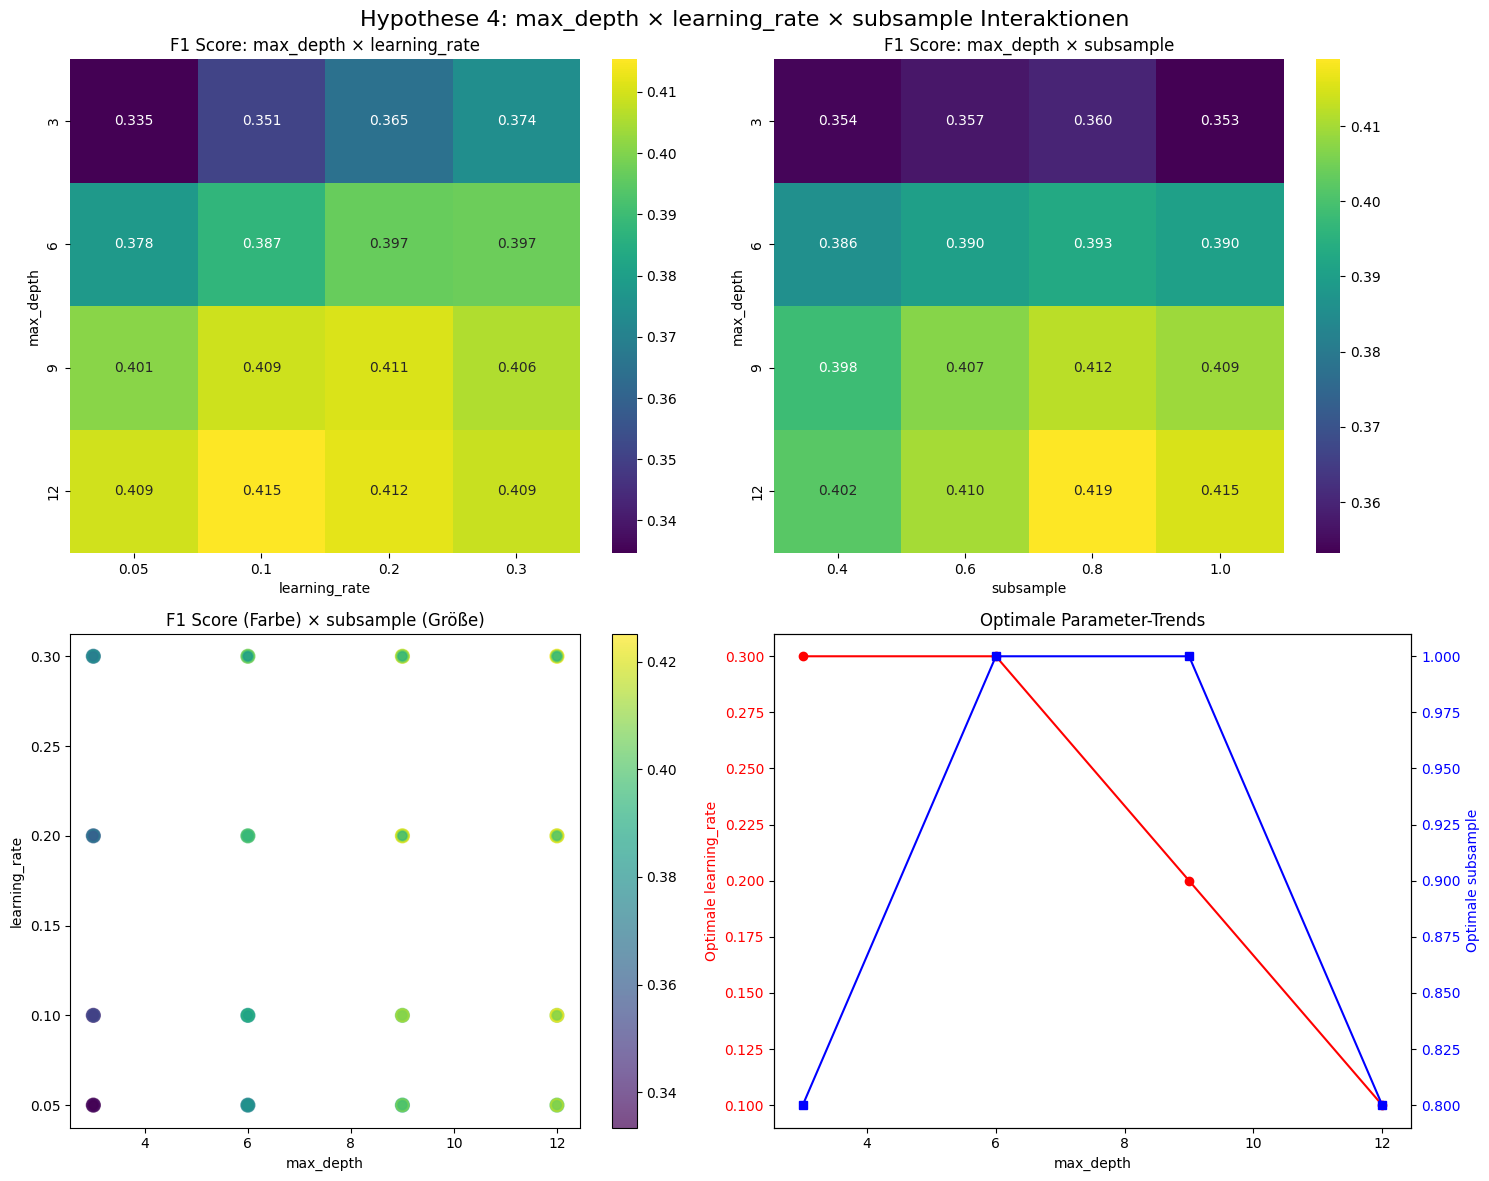

In [ ]:
# VISUALISIERUNG DER ERGEBNISSE
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hypothese 4: max_depth × learning_rate × subsample Interaktionen', fontsize=16)

# 1. Heatmap: max_depth vs learning_rate (aggregiert über subsample)
pivot_depth_lr = df_results_h4.groupby(['max_depth', 'learning_rate'])['f1_mean'].mean().unstack()
sns.heatmap(pivot_depth_lr, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('F1 Score: max_depth × learning_rate')
axes[0,0].set_ylabel('max_depth')

# 2. Heatmap: max_depth vs subsample (aggregiert über learning_rate)
pivot_depth_sub = df_results_h4.groupby(['max_depth', 'subsample'])['f1_mean'].mean().unstack()
sns.heatmap(pivot_depth_sub, annot=True, fmt='.3f', cmap='viridis', ax=axes[0,1])
axes[0,1].set_title('F1 Score: max_depth × subsample')
axes[0,1].set_ylabel('max_depth')

# 3. 3D Scatter: Performance vs alle 3 Parameter
scatter = axes[1,0].scatter(df_results_h4['max_depth'], 
                           df_results_h4['learning_rate'], 
                           c=df_results_h4['f1_mean'], 
                           s=df_results_h4['subsample']*100,
                           cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('max_depth')
axes[1,0].set_ylabel('learning_rate') 
axes[1,0].set_title('F1 Score (Farbe) × subsample (Größe)')
plt.colorbar(scatter, ax=axes[1,0])

# 4. Trend-Analyse: Optimale Parameter pro max_depth
best_per_depth_sorted = best_per_depth.sort_values('max_depth')
axes[1,1].plot(best_per_depth_sorted['max_depth'], best_per_depth_sorted['learning_rate'], 
               'o-', label='Optimale learning_rate', color='red')
axes[1,1].set_xlabel('max_depth')
axes[1,1].set_ylabel('Optimale learning_rate', color='red')
axes[1,1].tick_params(axis='y', labelcolor='red')

ax2 = axes[1,1].twinx()
ax2.plot(best_per_depth_sorted['max_depth'], best_per_depth_sorted['subsample'], 
         's-', label='Optimale subsample', color='blue')
ax2.set_ylabel('Optimale subsample', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
axes[1,1].set_title('Optimale Parameter-Trends')

plt.tight_layout()
plt.show()

### Finale Auswertung

In [ ]:
# Globale Hypothesen-Auswertung
print(f"\nFINALE BEWERTUNG HYPOTHESE 4:")
print("=" * 60)

# Trend-Koeffizienten berechnen
depths = sorted(param_grid_h4['max_depth'])
optimal_lrs = [best_per_depth[best_per_depth['max_depth']==d]['learning_rate'].iloc[0] for d in depths]
optimal_subs = [best_per_depth[best_per_depth['max_depth']==d]['subsample'].iloc[0] for d in depths]

lr_trend = np.corrcoef(depths, optimal_lrs)[0,1]
sub_trend = np.corrcoef(depths, optimal_subs)[0,1]

print(f"Trend-Koeffizient max_depth → learning_rate: {lr_trend:.3f} {'BESTÄTIGT' if lr_trend < -0.3 else 'WIDERLEGT'}")
print(f"Trend-Koeffizient max_depth → subsample:     {sub_trend:.3f} {'BESTÄTIGT' if sub_trend < -0.3 else 'WIDERLEGT'}")

if lr_trend < -0.3 and sub_trend < -0.3:
    print(f"\nHYPOTHESE 4 STARK BESTÄTIGT!")
    print(f"   Beide Trends zeigen deutliche negative Korrelation")
elif lr_trend < -0.1 and sub_trend < -0.1:
    print(f"\nHYPOTHESE 4 TEILWEISE BESTÄTIGT!")
    print(f"   Trends gehen in erwartete Richtung, aber schwächer")
else:
    print(f"\nHYPOTHESE 4 WIDERLEGT!")
    print(f"   Erwartete Trends nicht erkennbar")

# Performance-Vergleich: Hypothesen-konforme vs. nicht-konforme Configs
conforming_configs = []
non_conforming_configs = []

for _, row in df_results_h4.iterrows():
    # Regel: Hohe max_depth (≥9) sollte niedrige lr (≤0.1) UND niedrige subsample (≤0.6) haben
    if row['max_depth'] >= 9:
        if row['learning_rate'] <= 0.1 and row['subsample'] <= 0.6:
            conforming_configs.append(row)
        else:
            non_conforming_configs.append(row)
    # Regel: Niedrige max_depth (≤6) kann höhere lr UND subsample haben  
    elif row['max_depth'] <= 6:
        if row['learning_rate'] >= 0.1 or row['subsample'] >= 0.6:
            conforming_configs.append(row)
        else:
            non_conforming_configs.append(row)

if conforming_configs and non_conforming_configs:
    conf_f1 = np.mean([c['f1_mean'] for c in conforming_configs])
    non_conf_f1 = np.mean([c['f1_mean'] for c in non_conforming_configs])
    
    print(f"\nPERFORMANCE-VERGLEICH:")
    print(f"Hypothesen-konforme Configs:     F1 = {conf_f1:.4f} (n={len(conforming_configs)})")
    print(f"Hypothesen-widrige Configs:      F1 = {non_conf_f1:.4f} (n={len(non_conforming_configs)})")
    print(f"Performance-Differenz:           {conf_f1 - non_conf_f1:+.4f}")



FINALE BEWERTUNG HYPOTHESE 4:
Trend-Koeffizient max_depth → learning_rate: -0.944 BESTÄTIGT
Trend-Koeffizient max_depth → subsample:     0.000 WIDERLEGT

HYPOTHESE 4 WIDERLEGT!
   Erwartete Trends nicht erkennbar

PERFORMANCE-VERGLEICH:
Hypothesen-konforme Configs:     F1 = 0.3811 (n=38)
Hypothesen-widrige Configs:      F1 = 0.4054 (n=26)
Performance-Differenz:           -0.0243


## Hypothese 5: 

In [ ]:
# Parameter-Grid für Hypothese 5
param_grid_h5 = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 6, 9, 12],
    'subsample': [1.0, 0.8, 0.6, 0.4]
}

# Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_params(n_estimators, max_depth, subsample):
    """Evaluiert eine Parameterkombination mit Cross-Validation"""
    start_time = time.time()

    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=n_estimators,
        max_depth=max_depth,
        subsample=subsample,
        random_state=42
    )

    # Cross-Validation F1 Score (weighted)
    f1_scores = cross_val_score(
        model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1
    )

    # Cross-Validation Accuracy
    acc_scores = cross_val_score(
        model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1
    )

    execution_time = time.time() - start_time

    return {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'subsample': subsample,
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std(),
        'accuracy_mean': acc_scores.mean(),
        'accuracy_std': acc_scores.std(),
        'execution_time': execution_time
    }



In [ ]:
print("Starte Hypothese 5 Experimente...")
print("Erwartung: n_estimators↑ UND max_depth↑ → subsample↓")
print("=" * 60)

Starte Hypothese 5 Experimente...
Erwartung: n_estimators↑ UND max_depth↑ → subsample↓


In [ ]:
# Alle Parameterkombinationen testen
results_h5 = []
total_combinations = (
    len(param_grid_h5['n_estimators']) *
    len(param_grid_h5['max_depth']) *
    len(param_grid_h5['subsample'])
)

start_total_time = time.time()

for i, (n_estimators, max_depth, subsample) in enumerate(
    product(param_grid_h5['n_estimators'],
            param_grid_h5['max_depth'],
            param_grid_h5['subsample']), 1):

    print(f"[{i:2d}/{total_combinations}] Testing: n_estimators={n_estimators}, "
          f"max_depth={max_depth}, subsample={subsample}")

    result = evaluate_params(n_estimators, max_depth, subsample)
    results_h5.append(result)

    print(f"                F1: {result['f1_mean']:.4f}, Zeit: {result['execution_time']:.1f}s")

total_time = time.time() - start_total_time


# Ergebnisse in DataFrame
df_results_h5 = pd.DataFrame(results_h5)

print("\nTOP 10 Konfigurationen (nach F1 Score):")
print("=" * 60)
top_10_f1 = df_results_h5.nlargest(10, 'f1_mean')
for _, row in top_10_f1.iterrows():
    print(f"F1: {row['f1_mean']:.4f}±{row['f1_std']:.3f} | "
          f"Acc: {row['accuracy_mean']:.4f} | "
          f"n_estimators={int(row['n_estimators'])}, max_depth={int(row['max_depth'])}, subsample={row['subsample']}")

NameError: name 'time' is not defined